# Training a MACE model

In this notebook, the flow of training a MACE model is detailed step by step.

In [1]:
import matplotlib.pyplot    as plt
import numpy                as np      
import torch
from time                   import time
import datetime             as dt
from tqdm                   import tqdm

import src.mace.CSE_0D.dataset  as ds
import src.mace.train           as train
import src.mace.test            as test
import src.mace.mace            as mace
from src.mace.loss              import Loss
import src.mace.loss            as loss  
import src.mace.utils           as utils
from src.mace.input             import Input

specs_dict, idx_specs = utils.get_specs()

%reload_ext autoreload
%autoreload 2

## Setting up 



### Naming the model

The default model to name the model is with the date and time of training. This can be adjusted with changing the parameter *name*.

In [2]:
now = dt.datetime.now()
name = str(now.strftime("%Y%m%d")+'_'+now.strftime("%H%M%S"))

path = '/STER/silkem/MACE/models/CSE_0D/'+name

Make directories to store output and trained model.

In [3]:
utils.makeOutputDir(path)
utils.makeOutputDir(path+'/nn')

'/STER/silkem/MACE/models/CSE_0D/20240604_133932/nn'

### Reading input file

Fill in the name of the input file for *arg*.

In [4]:
arg = 'example'

In [5]:
infile = '/STER/silkem/MACE/input/'+arg+'.in'

input = Input(infile, name)

meta = input.make_meta(path)

input.print()

------------------------------
Name: 20240604_133932
------------------------------
     inputfile: /STER/silkem/MACE/input/example.in
      # hidden: 1
       ae type: simple
# z dimensions: 8
        scheme: loc
  # evolutions: 1
     loss type: abs_idn
      # epochs: 3
 learning rate: 1e-05



### Set up the model

Set up PyTorch.

In [6]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 
kwargs = {'num_workers': 1, 'pin_memory': True} 

Load the train, validation, and test data sets.

In [7]:
traindata, testdata, data_loader, test_loader = ds.get_data(dt_fract=input.dt_fract,
                                                            nb_samples=input.nb_samples, batch_size=batch_size, 
                                                            nb_test=input.nb_test,kwargs=kwargs)


Dataset:
------------------------------
  total # of samples: 100
#   training samples: 70
# validation samples: 30
               ratio: 0.3
     #  test samples: 2


Make the model, randomly initialised.

In [8]:
model = mace.Solver(n_dim=input.n_dim, p_dim=4,z_dim = input.z_dim, 
                    nb_hidden=input.nb_hidden, ae_type=input.ae_type, 
                    scheme=input.scheme, nb_evol=input.nb_evol,
                    path = path,
                    DEVICE = DEVICE,
                    lr=input.lr )

num_params = utils.count_parameters(model)
print(f'\nThe model has {num_params} trainable parameters')


The model has 284692 trainable parameters


## Training the model

Training the model in [Maes et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240503274M/abstract) happens it two stages:

1. For the first few epochs (*input.ini_epochs*) the models is trained with unscaled losses.
2. The losses of the model are rescaled, normalised based in the losses in the first few epochs.




### Stage 1

Initialise loss.

In [9]:
norm, fract = loss.initialise()

trainloss = Loss(norm, fract, input.losstype)
testloss  = Loss(norm, fract, input.losstype)

Train the model & time the training.


Local training scheme in use.

>>> Training model...


Epoch 1 complete! 	Average training loss:  15.82134 	Average validation loss:  6.63952
              time [mins]:  28625019.89552

 	DONE!


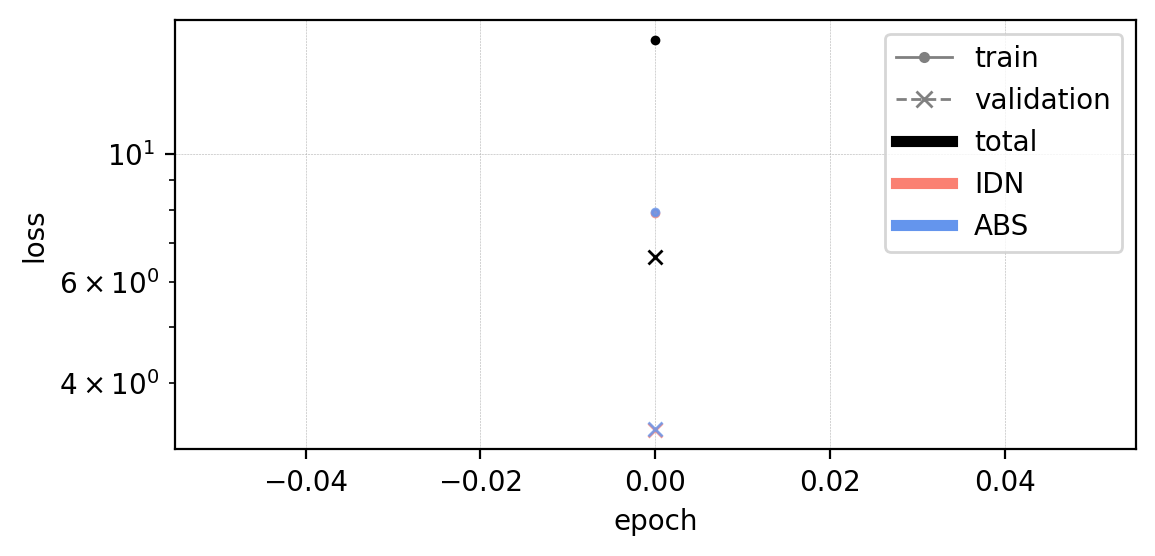

In [10]:
tic = time()
train.train(model, 
            data_loader, test_loader, 
            end_epochs = input.ini_epochs, 
            trainloss=trainloss, testloss=testloss)
toc = time()
train_time1 = toc-tic

### Stage 2

Normalise losses based on the past losses, and (optional) scale losses, given by parameter *fract*.

In [12]:
fract = input.get_facts()
trainloss.change_fract(fract)
testloss.change_fract(fract)

new_norm = trainloss.normalise()  
testloss.change_norm(new_norm) 

Continue the training.


Local training scheme in use.

>>> Training model...


Epoch 2 complete! 	Average training loss:  1.90596 	Average validation loss:  0.79177
              time [secs]:  7.14325
Epoch 3 complete! 	Average training loss:  1.76224 	Average validation loss:  0.71411
              time [secs]:  13.18228

 	DONE!

 >>> Plotting...


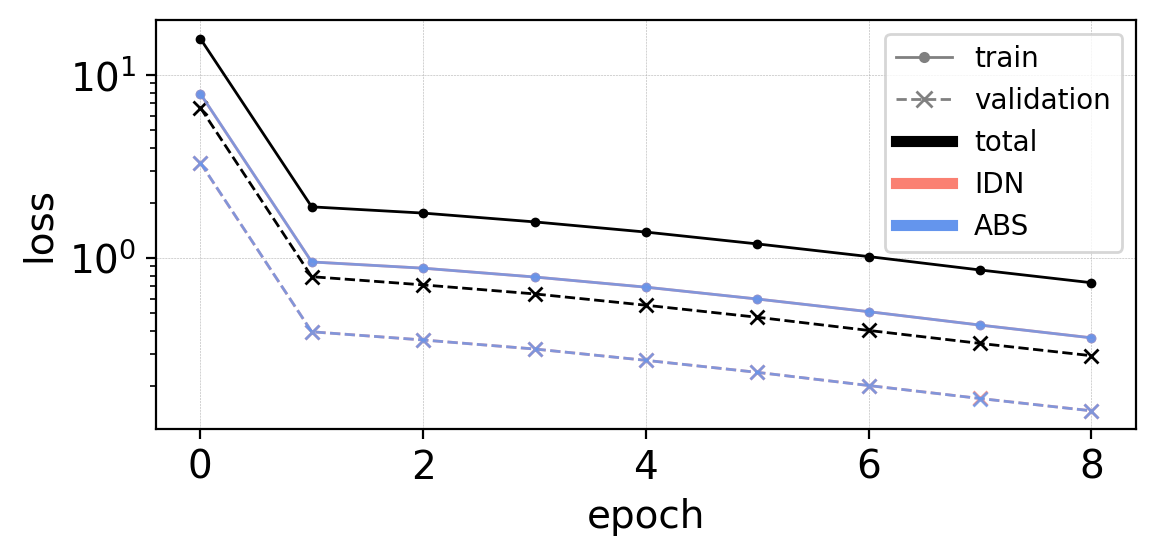

In [17]:
tic = time()
train.train(model, 
            data_loader, test_loader, 
            start_epochs = input.ini_epochs, end_epochs = input.nb_epochs, 
            trainloss=trainloss, testloss=testloss,
            plot = True)
toc = time()
train_time2 = toc-tic

train_time = train_time1 + train_time2

## Saving the model

Save the losses & specifics of the data set.

In [14]:
trainloss.save(path+'/train')
testloss.save(path+'/valid')

min_max = np.stack((traindata.mins, traindata.maxs), axis=1)
np.save(path+'/minmax', min_max) 

Save the model and the status of the solver (see [torchode status](https://github.com/martenlienen/torchode/blob/main/torchode/status_codes.py) for more details).

In [ ]:
torch.save(model.state_dict(),path+'/nn/nn.pt')

np.save(path+'/train/status', model.get_status('train')) # type: ignore
np.save(path +'/valid/status', model.get_status('test') ) # type: ignore

Plot the evolution of the loss and save the figure.

In [ ]:
fig_loss = loss.plot(trainloss, testloss, len = input.nb_epochs)
plt.savefig(path+'/loss.png')

## Testing the model

Perform tests on the trained model to get an accuracy indication, according to the following error metric:
$$ {\rm error} = \frac{\log_{10}\boldsymbol{n}-\log_{10}\hat{\boldsymbol{n}}}{\log_{10}\boldsymbol{n}}, $$
which is executed element-wise and subsequently summed over the different chemical species

### Performing the tests

In [18]:
sum_err_step = 0
sum_err_evol = 0

step_calctime = list()
evol_calctime = list()

for i in tqdm(range(len(traindata.testpath))):
#     print(i+1,end='\r')
    testpath = traindata.testpath[i]

    err_test, err_evol, step_time, evol_time = test.test_model(model,testpath, meta, printing = False)

    sum_err_step += err_test
    sum_err_evol += err_evol

    step_calctime.append(step_time)
    evol_calctime.append(evol_time)

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


### Saving the outcome of the tests

The error saved is normalised over the amount of tests, given by *len(traindata.testpath*.

In [19]:
utils.makeOutputDir(path+'/test')

np.save(path+ '/test/sum_err_step.npy', np.array(sum_err_step/len(traindata.testpath)))
np.save(path+ '/test/sum_err_evol.npy', np.array(sum_err_evol/len(traindata.testpath)))

np.save(path+ '/test/calctime_evol.npy', evol_calctime)
np.save(path+ '/test/calctime_step.npy', step_calctime)  

print('\nAverage error:')
print('           Step:', np.round(sum_err_step,3))
print('      Evolution:', np.round(sum_err_evol,3))


Average error:
           Step: 341.412
      Evolution: 357.766
